## **Human-Object Interaction Dectection Demo**


In [24]:
import os
if not os.path.exists('./checkpoints/vcoco/'):
    os.makedirs('./checkpoints/vcoco/')
if not os.path.exists('./checkpoints/hico-det/'):
    os.makedirs('./checkpoints/hico-det/')
if not os.path.exists('./v-coco/data/'):
    os.makedirs('./v-coco/data/')
if not os.path.exists('./hico_20160224_det/annotations/'):
    os.makedirs('./hico_20160224_det/annotations/')

In [5]:
#download pretrained weight
!wget https://arena.kakaocdn.net/brainrepo/hotr/vcoco_q16.pth -P ./checkpoints/vcoco/
!wget https://arena.kakaocdn.net/brainrepo/hotr/hico_ft_q16.pth -P ./checkpoints/hico-det/

--2022-02-21 18:30:04--  https://arena.kakaocdn.net/brainrepo/hotr/vcoco_q16.pth
Resolving arena.kakaocdn.net (arena.kakaocdn.net)... 203.217.239.86
Connecting to arena.kakaocdn.net (arena.kakaocdn.net)|203.217.239.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285415416 (272M) [application/zip]
Saving to: ‘./checkpoints/vcoco/vcoco_q16.pth.1’

vcoco_q16.pth.1     100%[===================>] 272.19M  38.6MB/s    in 8.8s    

2022-02-21 18:30:13 (30.9 MB/s) - ‘./checkpoints/vcoco/vcoco_q16.pth.1’ saved [285415416/285415416]

--2022-02-21 18:30:13--  https://arena.kakaocdn.net/brainrepo/hotr/hico_ft_q16.pth
Resolving arena.kakaocdn.net (arena.kakaocdn.net)... 203.217.239.86
Connecting to arena.kakaocdn.net (arena.kakaocdn.net)|203.217.239.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286942088 (274M) [application/zip]
Saving to: ‘./checkpoints/hico-det/hico_ft_q16.pth’

hico_ft_q16.pth     100%[===================>] 273.65M  31.

In [11]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached soupsieve-2.3.1-py3-none-any.whl (37 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=11b8ba6d515ca684e01f9306cbcbe05b4a748e205b45626bdb4740c35a454351
  Stored in directory: /home/jihwan/.cache/pip/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown


In [25]:
!wget 'https://drive.google.com/uc?id=1Oxqrbw-4htcQHTUmdeYAGI3ruhcR2Rzp' -O ./v-coco/data/instances_vcoco_all_2014.json
!wget 'https://drive.google.com/uc?id=1KG5zazXEUAts5zrmsGzQxZxwAMRwUz3y' -O ./hico_20160224_det/annotations/trainval_hico.json
!wget 'https://drive.google.com/uc?id=18HOXzEhkcsV5VlSQ7xoz96sgxxVSe3zy' -O ./hico_20160224_det/annotations/test_hico.json
!wget 'https://drive.google.com/uc?id=1Hr7K0EjChsKpGIGUvkany6CcMNAcUl4B' -O ./hico_20160224_det/annotations/corre_hico.npy
!wget 'https://drive.google.com/uc?id=1UhqUJMdKtHhOZ6gI8FUUlEc2w5Cx15xW' -O ./hico_20160224_det/list_action.txt

# https://drive.google.com/drive/folders/1UAI2Wp0iuQZT2LgnKdMC5g45-63arc1h?usp=sharing
# https://drive.google.com/drive/folders/1XSVY-ibi1BDV7DAQMa520nRjJrwJPJ7q?usp=sharing

--2022-02-21 20:37:28--  https://drive.google.com/uc?id=1Oxqrbw-4htcQHTUmdeYAGI3ruhcR2Rzp
Resolving drive.google.com (drive.google.com)... 172.217.161.78, 2404:6800:4004:80b::200e
Connecting to drive.google.com (drive.google.com)|172.217.161.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9hfu12ectnheac33p7f4q45rgpd5hp8l/1645443450000/04510992398135305556/*/1Oxqrbw-4htcQHTUmdeYAGI3ruhcR2Rzp [following]
--2022-02-21 20:37:33--  https://doc-0g-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9hfu12ectnheac33p7f4q45rgpd5hp8l/1645443450000/04510992398135305556/*/1Oxqrbw-4htcQHTUmdeYAGI3ruhcR2Rzp
Resolving doc-0g-as-docs.googleusercontent.com (doc-0g-as-docs.googleusercontent.com)... 142.251.42.161, 2404:6800:4004:826::2001
Connecting to doc-0g-as-docs.googleusercontent.com (doc-0g-as-docs.googleusercontent.com)|142.251.42.161|:443... 

In [9]:
# ------------------------------------------------------------------------
# HOTR official code : hotr/models/detr.py
# Copyright (c) Kakao Brain, Inc. and its affiliates. All Rights Reserved
# ------------------------------------------------------------------------
# Modified from DETR (https://github.com/facebookresearch/detr)
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
# ------------------------------------------------------------------------
"""
DETR & HOTR model and criterion classes.
"""
import torch
import torch.nn.functional as F
from torch import nn

from hotr.util.misc import (NestedTensor, nested_tensor_from_tensor_list)

from hotr.models.backbone import build_backbone
from hotr.models.detr_matcher import build_matcher
from hotr.models.hotr_matcher import build_hoi_matcher
from hotr.models.transformer import build_transformer, build_hoi_transformer
from hotr.models.criterion import SetCriterion
from hotr.models.post_process import PostProcess
from hotr.models.feed_forward import MLP
from hotr.models.hotr import HOTR as hotr

class HOTR(hotr):
    def __init__(self, detr,
                 num_hoi_queries,
                 num_actions,
                 interaction_transformer,
                 freeze_detr,
                 share_enc,
                 pretrained_dec,
                 temperature,
                 hoi_aux_loss,
                 return_obj_class=None):
        super().__init__(detr,
                 num_hoi_queries,
                 num_actions,
                 interaction_transformer,
                 freeze_detr,
                 share_enc,
                 pretrained_dec,
                 temperature,
                 hoi_aux_loss,
                 return_obj_class)
        hidden_dim=detr.transformer.d_model
        self.H_Pointer_embed   = MLP(hidden_dim, hidden_dim, hidden_dim, 3)
        self.O_Pointer_embed   = MLP(hidden_dim, hidden_dim, hidden_dim, 3)
        self.tau = temperature
    def forward(self, samples: NestedTensor):
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        
        # >>>>>>>>>>>>  BACKBONE LAYERS  <<<<<<<<<<<<<<<
        features, pos = self.detr.backbone(samples)
        bs = features[-1].tensors.shape[0]
        src, mask = features[-1].decompose()
        assert mask is not None
        # ----------------------------------------------

        # >>>>>>>>>>>> OBJECT DETECTION LAYERS <<<<<<<<<<
        start_time = time.time()
        hs, _ = self.detr.transformer(self.detr.input_proj(src), mask, self.detr.query_embed.weight, pos[-1])
        inst_repr = F.normalize(hs[-1], p=2, dim=2) # instance representations

        # Prediction Heads for Object Detection
        outputs_class = self.detr.class_embed(hs)
        outputs_coord = self.detr.bbox_embed(hs).sigmoid()
        object_detection_time = time.time() - start_time
        # -----------------------------------------------

        # >>>>>>>>>>>> HOI DETECTION LAYERS <<<<<<<<<<<<<<<
        start_time = time.time()
        assert hasattr(self, 'interaction_transformer'), "Missing Interaction Transformer."
        interaction_hs = self.interaction_transformer(self.detr.input_proj(src), mask, self.query_embed.weight, pos[-1])[0] # interaction representations
    
        # [HO Pointers]
        H_Pointer_reprs = F.normalize(self.H_Pointer_embed(interaction_hs), p=2, dim=-1)
        O_Pointer_reprs = F.normalize(self.O_Pointer_embed(interaction_hs), p=2, dim=-1)
        outputs_hidx = [(torch.bmm(H_Pointer_repr, inst_repr.transpose(1,2))) / self.tau for H_Pointer_repr in H_Pointer_reprs]
        outputs_oidx = [(torch.bmm(O_Pointer_repr, inst_repr.transpose(1,2))) / self.tau for O_Pointer_repr in O_Pointer_reprs]
        
        # [Action Classification]
        outputs_action = self.action_embed(interaction_hs)
        # --------------------------------------------------
        hoi_detection_time = time.time() - start_time
        hoi_recognition_time = max(hoi_detection_time - object_detection_time, 0)
        # -------------------------------------------------------------------

        # [Target Classification]
        if self.return_obj_class:
            detr_logits = outputs_class[-1, ..., self._valid_obj_ids]
            o_indices = [output_oidx.max(-1)[-1] for output_oidx in outputs_oidx]
            obj_logit_stack = [torch.stack([detr_logits[batch_, o_idx, :] for batch_, o_idx in enumerate(o_indice)], 0) for o_indice in o_indices]
            outputs_obj_class = obj_logit_stack

        out = {
            "pred_logits": outputs_class[-1],
            "pred_boxes": outputs_coord[-1],
            "pred_hidx": outputs_hidx[-1],
            "pred_oidx": outputs_oidx[-1],
            "pred_actions": outputs_action[-1],
            "hoi_recognition_time": hoi_recognition_time,
        }

        if self.return_obj_class: out["pred_obj_logits"] = outputs_obj_class[-1]

        if self.hoi_aux_loss: # auxiliary loss
            out['hoi_aux_outputs'] = \
                self._set_aux_loss_with_tgt(outputs_class, outputs_coord, outputs_hidx, outputs_oidx, outputs_action, outputs_obj_class) \
                if self.return_obj_class else \
                self._set_aux_loss(outputs_class, outputs_coord, outputs_hidx, outputs_oidx, outputs_action)

        return out

In [10]:
class DETR(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels
            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.backbone(samples)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]

        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)

        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]
def build_model(args):
    device = torch.device(args.device)

    backbone = build_backbone(args)

    transformer = build_transformer(args)

    model = DETR(
        backbone,
        transformer,
        num_classes=args.num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )

    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef

    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality'] if args.frozen_weights is None else []
    if args.HOIDet:
        hoi_matcher = build_hoi_matcher(args)
        hoi_losses = []
        hoi_losses.append('pair_labels')
        hoi_losses.append('pair_actions')
        if args.dataset_file == 'hico-det': hoi_losses.append('pair_targets')
        
        hoi_weight_dict={}
        hoi_weight_dict['loss_hidx'] = args.hoi_idx_loss_coef
        hoi_weight_dict['loss_oidx'] = args.hoi_idx_loss_coef
        hoi_weight_dict['loss_act'] = args.hoi_act_loss_coef
        if args.dataset_file == 'hico-det': hoi_weight_dict['loss_tgt'] = args.hoi_tgt_loss_coef
        if args.hoi_aux_loss:
            hoi_aux_weight_dict = {}
            for i in range(args.hoi_dec_layers):
                hoi_aux_weight_dict.update({k + f'_{i}': v for k, v in hoi_weight_dict.items()})
            hoi_weight_dict.update(hoi_aux_weight_dict)

        criterion = SetCriterion(args.num_classes, matcher=matcher, weight_dict=hoi_weight_dict,
                                 eos_coef=args.eos_coef, losses=losses, num_actions=args.num_actions,
                                 HOI_losses=hoi_losses, HOI_matcher=hoi_matcher, args=args)

        interaction_transformer = build_hoi_transformer(args) # if (args.share_enc and args.pretrained_dec) else None

        kwargs = {}
        if args.dataset_file == 'hico-det': kwargs['return_obj_class'] = args.valid_obj_ids
        model = HOTR(
            detr=model,
            num_hoi_queries=args.num_hoi_queries,
            num_actions=args.num_actions,
            interaction_transformer=interaction_transformer,
            freeze_detr=(args.frozen_weights is not None),
            share_enc=args.share_enc,
            pretrained_dec=args.pretrained_dec,
            temperature=args.temperature,
            hoi_aux_loss=args.hoi_aux_loss,
            **kwargs # only return verb class for HICO-DET dataset
        )
        postprocessors = {'hoi': PostProcess(args.HOIDet)}
    else:
        criterion = SetCriterion(args.num_classes, matcher=matcher, weight_dict=weight_dict,
                                 eos_coef=args.eos_coef, losses=losses)
        postprocessors = {'bbox': PostProcess(args.HOIDet)}
    criterion.to(device)

    return model, criterion, postprocessors

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import cv2


vcoco_action_string = {2: 'hold', 3: 'stand', 4: 'sit', 5: 'ride', 6: 'walk',\
                       7: 'look', 8: 'hit_inst', 9: 'hit_obj', 10: 'eat_obj', \
                       11: 'eat_inst', 12: 'jump', 13: 'lay', 14: 'talk', 15: \
                       'carry', 16: 'throw', 17: 'catch', 18: 'cut_inst', 19:'cut_obj', \
                       20: 'run', 21: 'work_on_comp', 22: 'ski', 23: 'surf', 24: 'skateboard', \
                       25: 'smile', 26: 'drink', 27: 'kick', 28: 'point', 29: 'read', 30: 'snowboard'}
def draw_box_on_img(box, img,color=None):

    vis_img = img.copy()
    box = [int(x) for x in box]
    cv2.rectangle(vis_img, (box[0], box[1]), (box[2], box[3]), color, 2)
    draw_point=[int((box[0]+box[2])*1.0/2),int((box[1]+box[3])*1.0/2)]
    
    return vis_img,color


def draw_line_on_img_vcoco(box,line, img, class_index,color):
    
    vis_img = img.copy()
    font=cv2.FONT_HERSHEY_SIMPLEX
    x=int(box[0])+2
    y=int(box[1])+2
    f=int(box[1])+2
    for i in range(len(class_index)):
     
        font_scale=1
        font_thickness=2
    
        text_size, _ = cv2.getTextSize(vcoco_action_string[class_index[i]] , font, font_scale, font_thickness)
        vis_img=cv2.rectangle(vis_img,(x,y),(x+text_size[0],y+text_size[1]+5),color[1],-1)
        

        vis_img=cv2.putText(vis_img, vcoco_action_string[class_index[i]] ,(x,y + text_size[1] ),font,font_scale,[0,0,0],font_thickness)
        y=y+text_size[1]+5
   
    return vis_img,y


def draw_img_vcoco(img, output_i, top_k,threshold,color):
    list_action = []
    for action in output_i['hoi_prediction']:
        subject_id = action['subject_id']
        object_id = action['object_id']
        category_id = action['category_id']
        score = action['score']
        single_out = [subject_id,object_id,category_id,score]
        list_action.append(single_out)
    list_action = sorted(list_action, key=lambda x:x[-1], reverse=True)
    action_dict = []
    action_cate = []
    action_color=[]
    subj_box=[]
    sb={}
    sbj=[]
    for action in list_action[:top_k]:
        print(action)
        subject_id,object_id,category_id,score = action
        if score<threshold:
            break
        subject_obj = output_i['predictions'][subject_id]
        subject_box = subject_obj['bbox']
        object_obj = output_i['predictions'][object_id]
        object_box = object_obj['bbox']

        point_1 = [int((subject_box[0]+subject_box[2])*1.0/2),int((subject_box[1]+subject_box[3])*1.0/2)]
        point_2 = [int((object_box[0]+object_box[2])*1.0/2),int((object_box[1]+object_box[3])*1.0/2)]
  
        if [point_1,point_2] not in action_dict:
            
            img,color_hum = draw_box_on_img(subject_box, img, color[subject_obj['category_id']]['color'])
            
            img,color_obj = draw_box_on_img(object_box, img, color[object_obj['category_id']]['color'])
            
            action_dict.append([point_1,point_2])
            action_color.append([color_hum,color_obj])
            subj_box.append([int(subject_box[0]),int(subject_box[1])])    
           
        action_cate.append([])
        action_cate[action_dict.index([point_1,point_2])].append(category_id)

    for i,(action_item,clr) in enumerate(zip(action_dict,action_color)):
        
        
        # box=sb[]
        img,offset = draw_line_on_img_vcoco(subj_box[i],action_item,img,action_cate[action_dict.index(action_item)],clr)
        # import pdb;pdb.set_trace()
        
        for p in range(i+1,len(subj_box)):
            if subj_box[p]==subj_box[i]:
                subj_box[p][1]=offset
    return img

In [17]:
import argparse
import datetime
import json
import random
import time
import multiprocessing
from pathlib import Path
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import hotr.data.datasets as datasets
import hotr.util.misc as utils
from hotr.engine.arg_parser import get_args_parser
from hotr.data.datasets import build_dataset, get_coco_api_from_dataset
from hotr.data.datasets.vcoco import make_hoi_transforms
from PIL import Image
from hotr.util.logger import print_params, print_args
import os
import cv2
import numpy as np

import copy
from hotr.data.datasets import builtin_meta
from PIL import Image
import requests
import mmcv
from matplotlib import pyplot as plt

def change_format(results,valid_ids):
    
    boxes,labels,pair_score =\
                    list(map(lambda x: x.cpu().numpy(), [results['boxes'], results['labels'], results['pair_score']]))
    output_i={}
    output_i['predictions']=[]
    output_i['hoi_prediction']=[]
    # pdb.set_trace()
    h_idx=np.where(labels==1)[0]
    for box,label in zip(boxes,labels):
        
        output_i['predictions'].append({'bbox':box.tolist(),'category_id':label})
    
    for i,verb in enumerate(pair_score):
        if i in [1,4,10,23,26,5,18]:
            continue
        for j,hum in enumerate(h_idx):
            for k in range(len(boxes)):
                if verb[j][k]>0.4:
                    output_i['hoi_prediction'].append({'subject_id':hum,'object_id':k,'category_id':i+2,'score':verb[j][k]})
            
    return output_i
def vis(args,id=294):
#     utils.init_distributed_mode(args)

    if args.frozen_weights is not None:
        print("Freeze weights for detector")

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Data Setup
    dataset_train = build_dataset(image_set='train', args=args)
    args.num_classes = dataset_train.num_category()
    args.num_actions = dataset_train.num_action()
    args.action_names = dataset_train.get_actions()
    if args.share_enc: args.hoi_enc_layers = args.enc_layers
    if args.pretrained_dec: args.hoi_dec_layers = args.dec_layers
    if args.dataset_file == 'vcoco':
        # Save V-COCO dataset statistics
        args.valid_ids = np.array(dataset_train.get_object_label_idx()).nonzero()[0]
        args.invalid_ids = np.argwhere(np.array(dataset_train.get_object_label_idx()) == 0).squeeze(1)
        args.human_actions = dataset_train.get_human_action()
        args.object_actions = dataset_train.get_object_action()
        args.num_human_act = dataset_train.num_human_act()
    elif args.dataset_file == 'hico-det':
        args.valid_obj_ids = dataset_train.get_valid_obj_ids()
    print_args(args)

    args.HOIDet=True
    args.eval=True
    args.pretrained_dec=True
    args.share_enc=True
    if args.dataset_file=='hico-det':
        args.valid_ids=args.valid_obj_ids
 
    # Model Setup
    model, criterion, postprocessors = build_model(args)
    model.to(device)

    model_without_ddp = model

    n_parameters = print_params(model)

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]

    output_dir = Path(args.output_dir)
    
    checkpoint = torch.load(args.resume, map_location='cpu')
    #수정
    module_name=list(checkpoint['model'].keys())
    model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
    if not args.video_vis:
        url='http://images.cocodataset.org/val2014/COCO_val2014_{}.jpg'.format(str(id).zfill(12))
        req = requests.get(url, stream=True, timeout=1, verify=False).raw
        img = Image.open(req).convert('RGB')

        w,h=img.size
        orig_size = torch.as_tensor([int(h), int(w)]).unsqueeze(0).to(device)

        # pdb.set_trace()
        transform=make_hoi_transforms('val')
        sample=img.copy()
        sample,_=transform(sample,None)
        sample = sample.unsqueeze(0).to(device)
        with torch.no_grad():
            model.eval()
            out=model(sample)
            results = postprocessors['hoi'](out, orig_size,dataset=args.dataset_file)
            output_i=change_format(results[0],args.valid_ids)

        out_dir = './vis'
        image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
        image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

        vis_img=draw_img_vcoco(image,output_i,top_k=10,threshold=0.3,color=builtin_meta.COCO_CATEGORIES)
#         cv2.imshow('./sample.jpg', vis_img)
        
        plt.imshow(cv2.cvtColor(vis_img,cv2.COLOR_BGR2RGB))
    else:
        video_file='tri_cut'
    
        video_reader = mmcv.VideoReader('./vid/'+video_file+'.mp4')
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(
                './vid/'+video_file+'_vis.mp4', fourcc, video_reader.fps,
                (video_reader.width, video_reader.height))

        orig_size = torch.as_tensor([int(video_reader.height), int(video_reader.width)]).unsqueeze(0).to(device)
        transform=make_hoi_transforms('val')

        for frame in mmcv.track_iter_progress(video_reader):

            frame=mmcv.imread(frame)
            frame=frame.copy()
  
            frame=Image.fromarray(frame,'RGB')

            sample,_=transform(frame,None)
            sample=sample.unsqueeze(0).to(device)

            with torch.no_grad():
                model.eval()
                out=model(sample)
                results = postprocessors['hoi'](out, orig_size,dataset='vcoco')
                output_i=change_format(results[0],args.valid_ids)

            vis_img=draw_img_vcoco(np.array(frame),output_i,top_k=10,threshold=0.4,color=builtin_meta.COCO_CATEGORIES)

            video_writer.write(vis_img)
        if video_writer:
            video_writer.release()
        cv2.destroyAllWindows()
 

def visualization(id,video_vis=False,dataset_file='vcoco',data_path='v-coco'):

    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    checkpoint_dir= './checkpoints/vcoco/vcoco_q16.pth' if dataset_file=='vcoco' else './checkpoints/hico-det/hico_ft_q16.pth'
#     checkpoint_dir='./checkpoints/checkpoint.pth'
    args = parser.parse_args(args=['--dataset_file',dataset_file,'--data_path',data_path,'--resume',checkpoint_dir,'--num_hoi_queries' ,'16','--temperature' ,'0.05' ])
    args.video_vis=video_vis
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    vis(args,id)


loading annotations into memory...
Done (t=1.45s)
creating index...
index created!

[Logger] DETR Arguments:
	lr: 0.0001
	lr_backbone: 1e-05
	lr_drop: 80
	frozen_weights: None
	backbone: resnet50
	dilation: False
	position_embedding: sine
	enc_layers: 6
	dec_layers: 6
	num_queries: 100
	dataset_file: vcoco

[Logger] Number of params:  51181950
[71, 58, 2, 0.52673376]
[71, 57, 10, 0.50151867]
[71, 58, 10, 0.49138477]
[71, 57, 2, 0.48604298]


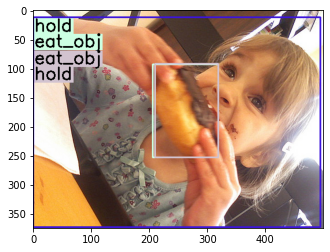

In [18]:
visualization(2225,dataset_file='vcoco',data_path='v-coco')

In [9]:
visualization(id=None,video_vis=True,dataset_file='vcoco',data_path='v-coco')

loading annotations into memory...
Done (t=1.31s)
creating index...
index created!

[Logger] DETR Arguments:
	lr: 0.0001
	lr_backbone: 1e-05
	lr_drop: 80
	frozen_weights: None
	backbone: resnet50
	dilation: False
	position_embedding: sine
	enc_layers: 6
	dec_layers: 6
	num_queries: 100
	dataset_file: vcoco

[Logger] Number of params:  51181950
[                                                  ] 0/58, elapsed: 0s, ETA:[67, 2, 4, 1.1916046]
[67, 2, 5, 1.1275864]
[90, 92, 4, 1.07879]
[90, 92, 5, 1.0062454]
[67, 2, 2, 0.9130995]
[90, 92, 2, 0.6839678]
[                                  ] 1/58, 1.1 task/s, elapsed: 1s, ETA:    54s[90, 92, 4, 0.9094516]
[67, 55, 4, 0.8613712]
[90, 92, 5, 0.792617]
[67, 55, 5, 0.75716704]
[90, 92, 2, 0.69563067]
[67, 55, 2, 0.66163707]
[>                                 ] 2/58, 1.1 task/s, elapsed: 2s, ETA:    49s[90, 92, 4, 1.2352052]
[90, 92, 5, 1.1401542]
[67, 2, 4, 1.0897276]
[67, 2, 5, 1.0216225]
[67, 2, 2, 0.84779733]
[90, 92, 2, 0.79288983]
[>        

[>>>>>>>>>>>>>>>>>>>             ] 36/58, 1.5 task/s, elapsed: 24s, ETA:    15s[90, 95, 5, 1.0736623]
[90, 95, 4, 1.0662475]
[67, 2, 4, 0.7948164]
[67, 2, 5, 0.73343635]
[90, 95, 2, 0.72838306]
[67, 2, 2, 0.6690613]
[>>>>>>>>>>>>>>>>>>>>            ] 37/58, 1.5 task/s, elapsed: 25s, ETA:    14s[90, 95, 5, 1.1728947]
[90, 95, 4, 1.1662457]
[67, 2, 4, 0.7589073]
[90, 95, 2, 0.7265616]
[67, 2, 5, 0.68570936]
[67, 2, 2, 0.6008487]
[>>>>>>>>>>>>>>>>>>>>            ] 38/58, 1.5 task/s, elapsed: 26s, ETA:    14s[71, 95, 5, 1.262007]
[71, 95, 4, 1.2533429]
[71, 95, 2, 0.7899218]
[67, 2, 4, 0.74960446]
[67, 2, 5, 0.6879924]
[67, 2, 2, 0.6232222]
[>>>>>>>>>>>>>>>>>>>>>           ] 39/58, 1.5 task/s, elapsed: 26s, ETA:    13s[67, 2, 4, 0.991271]
[71, 95, 4, 0.91190636]
[67, 2, 5, 0.8967848]
[71, 95, 5, 0.86354]
[67, 2, 2, 0.75726616]
[71, 95, 2, 0.59560585]
[>>>>>>>>>>>>>>>>>>>>>>          ] 40/58, 1.5 task/s, elapsed: 27s, ETA:    12s[90, 92, 4, 1.147217]
[90, 92, 5, 1.1264567]
[67, 2, 4, 0.8953

id=1655